In [2]:
# Code Adapted from https://github.com/a-martyn/ISL-python
# Comments by Soumitra Pandit

import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
from ipywidgets import interact
import ipywidgets as widgets
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz 
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier

**P8**\
Predicting sales using Regression trees.

**a) and b)**\
Split data into test and train and fit a regression tree.

In [4]:
carseats_df = pd.read_csv(r"C:\Users\smtrp\OneDrive\Desktop\DS502\ISLR\Data_Sets\Carseats.csv")

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0
# Drop unused index
#carseats_df = carseats_df.drop('Unnamed: 0', axis=1)

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.5

display(carseats_df.head())

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [5]:
# Use all features excpet response features
# No intercept

preds = carseats_df.columns.drop(['Sales'])
#preds_scaled = ['standardize({})'.format(p) for p in preds]
f = 'Sales ~ 0 +' + ' + '.join(preds)
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearn's tree regressor
clf = tree.DecisionTreeRegressor(max_depth=5).fit(X[train], y[train])

# Measure test set MSE
y_hat = clf.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE: {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

Test MSE: 5.09
Test RMSE: 2.256


**c)** \
Use Cross Validation to determine optimal tree density.\
Now I have followed this guy's code and I think his approach is smart.
Comparing number of leaf nodes is a very Comp_Sci solution, if you know what I mean - very hack-y. 

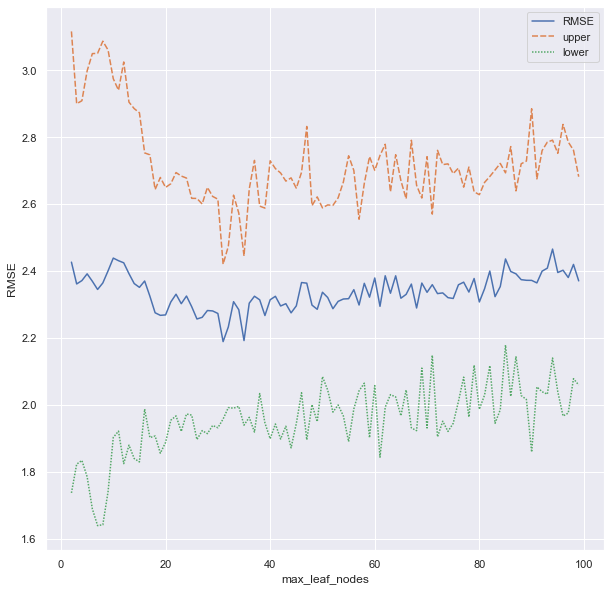

,RMSE,upper,lower
max_leaf_nodes,,,
31.0,2.188901,2.4201,1.957702


Test MSE : 4.661
Test RMSE: 2.159


In [6]:
# How about using CV to compare trees with different number of leaf nodes 
# as defined by the max_leaf_nodes parameter?

cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']

results = []
for m in np.arange(2, 100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X[train], y[train], cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)

# Use chosen model for test prediction
regr  = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)

# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

**d)**\
Bagging with 100 trees

In [7]:
# Bagging with 100 trees
# although I'm using RandomForestRegressor algo here this is Bagging because max_features = n_predictors

max_features = X.shape[1]
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(rmse, 3)))

Test MSE : 2.611
Test RMSE: 1.616


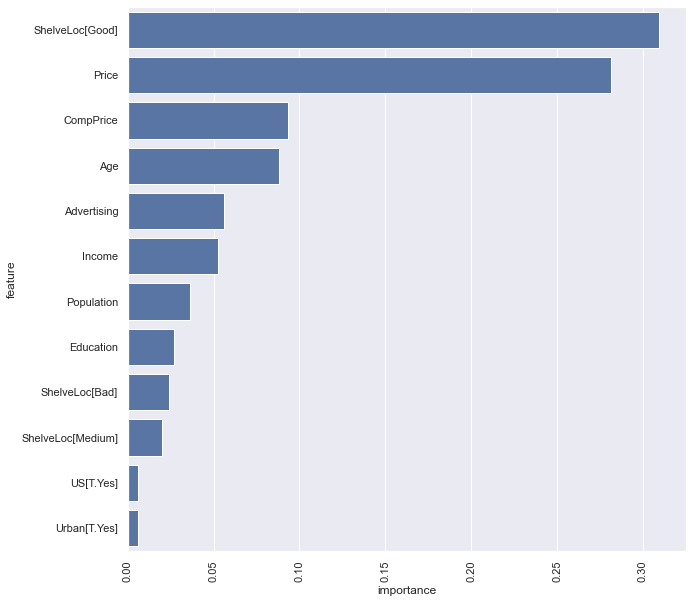

In [8]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);


**Comments**\
Okay, so bagging better than Tree pruning? Because the MSE has imporved. I think so.

**e)**\
Wait what? I am confused by this part. "The number of variables considered at each split".
I guess random forests work best with a smaller subset of features to choose from but there must be limit on how low you can go right? 
Also how many am I supposed to try out? You know what, its late, I am just going to follow the tutorial.

In [9]:
# Random Forest with 100 trees and 4 features considered at each split
# So we are using the magic number 4 for some reason. Would someone please explain the why behind this number?
max_features = 7
tree_count   = 100

regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
regr.fit(X[train], y[train])
y_hat = regr.predict(X[~train])

mse = metrics.mean_squared_error(y[~train], y_hat)
rmse = np.sqrt(mse)

print('MSE test: {}'.format(np.around(mse, 3)))
print('RMSE test: {}'.format(np.around(rmse, 3)))

MSE test: 2.566
RMSE test: 1.602


**comment**\
Wow the performance improved on even Bagging! That's quite neat actually.

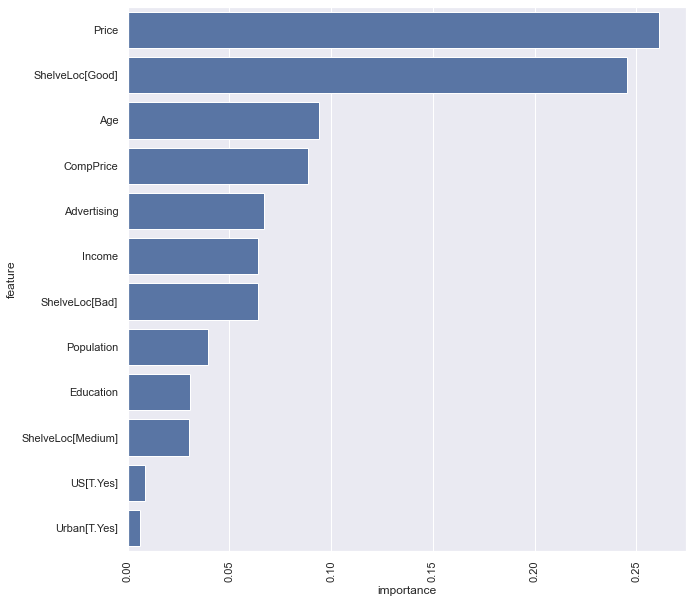

In [10]:
# Plot feature by importance in this model
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': regr.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
            color='b')
plt.xticks(rotation=90);


**Finally, some answers!**\
Okay so finally we are testing the optimal number of predictors to use at each node.\
Fantastic. That's what I have always wanted. Clarity.

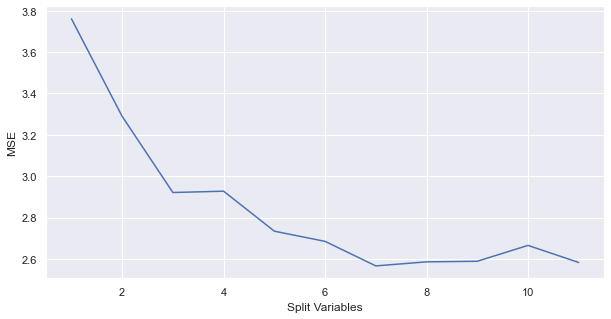

In [11]:
# Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

results = []
for max_features in np.arange(1, X.shape[1]):

    tree_count   = 100
    
    regr   = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
    regr.fit(X[train], y[train])
    y_hat = regr.predict(X[~train])
    
    mse = metrics.mean_squared_error(y[~train], y_hat)
    rmse = np.sqrt(mse)
    
    results += [[max_features, mse]]

plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']));